<a href="https://colab.research.google.com/github/javmencia/RBLog/blob/main/RegressionModelv12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import arviz as az

import pymc as pm
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.special import gammaln
from scipy import stats
import time
import math

def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

Bias Against

In [1]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    # Likelihood
    mu = pm.Deterministic("mu", pm.math.dot(X, beta))
    y_ = pm.MvNormal('y_', mu=mu, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_beta = pm.MvNormal(f'prior_beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p))
    prior_pdl = pm.Deterministic(f'prior_pdl', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)
    mean_beta_post = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, y)) + np.dot(Sigma_beta_inv, beta0))
    mean_beta = pm.Deterministic('mean_beta', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, y_)) + np.dot(Sigma_beta_inv, beta0)))

    # Posterior distribution for beta at each point
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_beta, cov=cov_beta_post, shape=p), beta))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pdl)

    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), y_).sum())
    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



y [-1.54850178  3.11291686  1.04629263  1.07816236  5.09347245 -0.39097253
 -1.50332568 -0.06068832 -2.61176071  0.86820256]


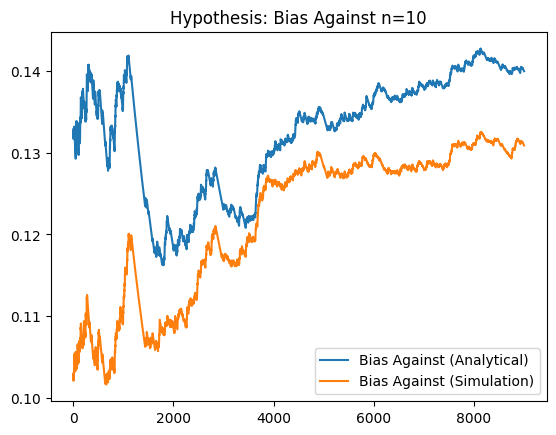

In [2]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time

def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

# Calculate the bias against the prior hypothesis
bias_against = idata.posterior["logBR_prior_pdl"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata.posterior['beta'][:, :, 0].values.ravel()[:1000]
x_samples = idata.posterior['y_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pdl'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against n={}".format(n))
plt.legend()
plt.show()

Bias In Favor

In [10]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]
# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)

print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)


with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p)
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)
    mu = pm.Deterministic('mu', pm.math.dot(X, beta))

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma0**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma0**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta0))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yl_)) + np.dot(Sigma_beta_inv, beta0)))
    #mean_betal = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + np.dot(Sigma_beta_inv, beta0))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, cov=cov_beta_post, shape=p), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yu_)) + np.dot(Sigma_beta_inv, beta0)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, cov=cov_beta_post, shape=p), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



y [ 0.09392613 -6.46955131  3.04150043 -0.25573974 -1.1901444   1.21906695
  2.29516562 -3.52780356  2.62423495 -1.69463182]


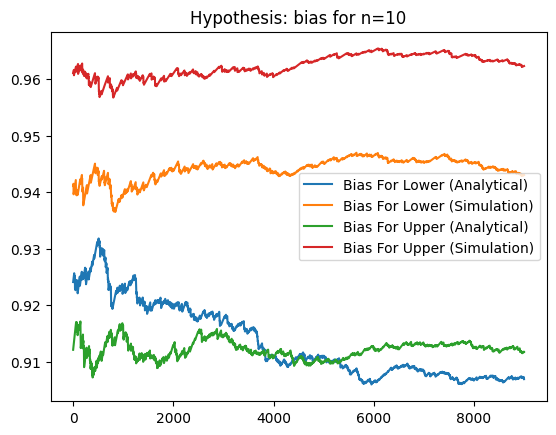

In [11]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


Shapes

In [12]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
mu0 = np.dot(X, beta0)
delta = 0.05
sigma0 = 1

# Generate points on the circle
num_points = 20  # Number of points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
circle_points = np.column_stack((beta0[0] + delta * np.cos(theta), beta0[1] + delta * np.sin(theta)))

num_points = len(circle_points)

# Vectorized response variable generation
muls = np.dot(X, circle_points.T).T  # Shape: (25, n)
yls = muls + np.random.normal(0, sigma0, (num_points, n))  # Shape: (25, n)

start_time = time.time()

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p)
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    mu = pm.Deterministic("mu", pm.math.dot(X, beta))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    # Iterate over each point on the circle
    for i, betal in enumerate(circle_points):
        # Likelihood
        mu_l = np.dot(X, betal)
        yl_ = pm.MvNormal(f'yl_{i}', mu=mu_l, cov=(sigma0**2) * np.eye(n), shape=n)

        # Prior for beta at each point
        prior_pd = pm.Deterministic(f'prior_pd_{i}', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta0))

        #Lower
        mean_betal = pm.Deterministic(f'mean_betal_{i}', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yl_)) + np.dot(Sigma_beta_inv, betal)))
        posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mean_betal, cov=cov_beta_post, shape=p), beta0))



        # Log BR
        logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - prior_pd)


        # Likelihood
        likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())


    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Cell execution time: {elapsed_time:.2f} seconds")



Cell execution time: 594.80 seconds


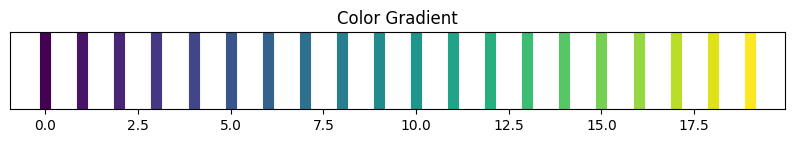

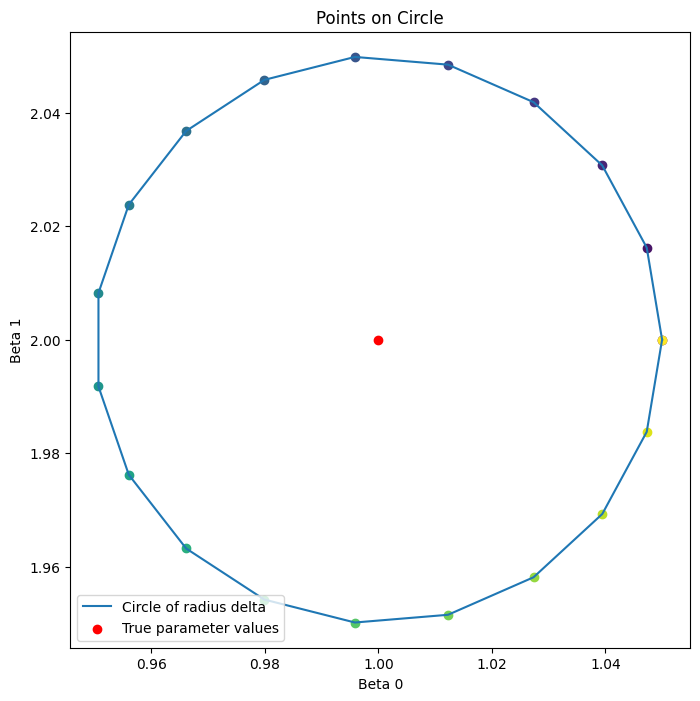

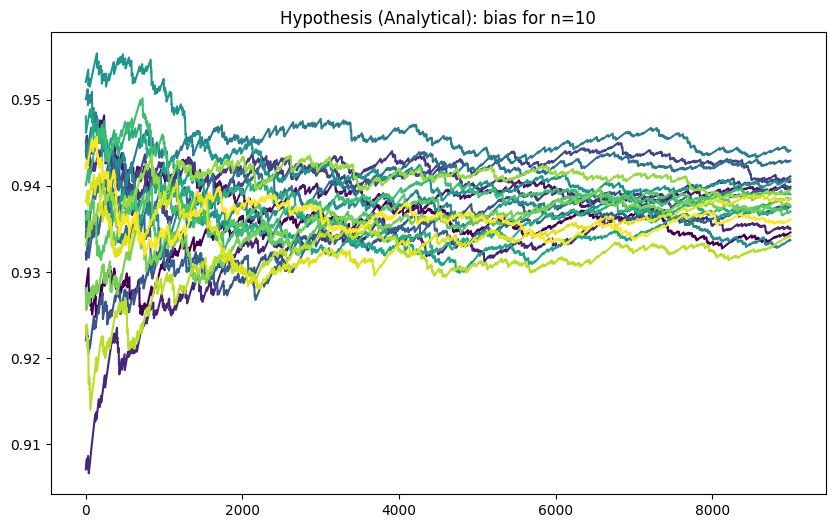

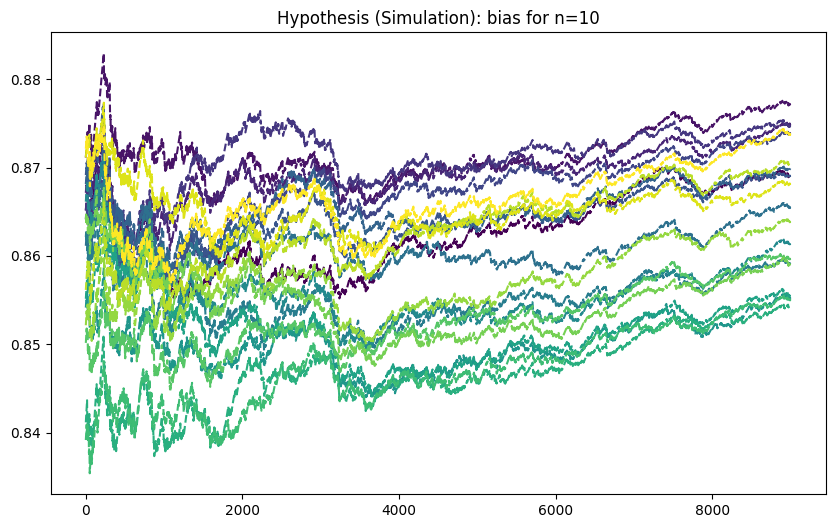

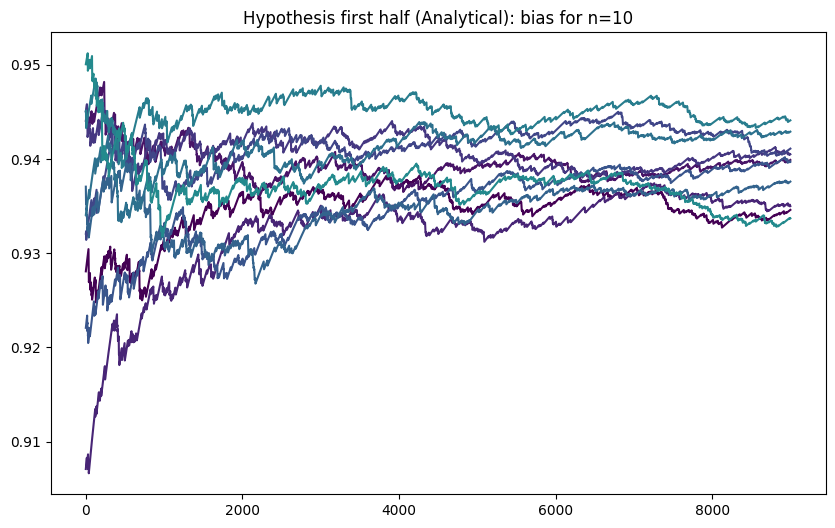

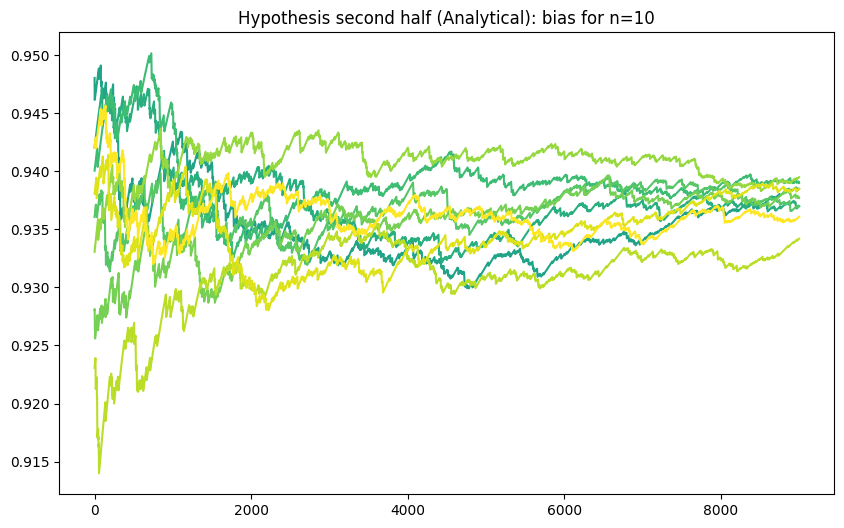

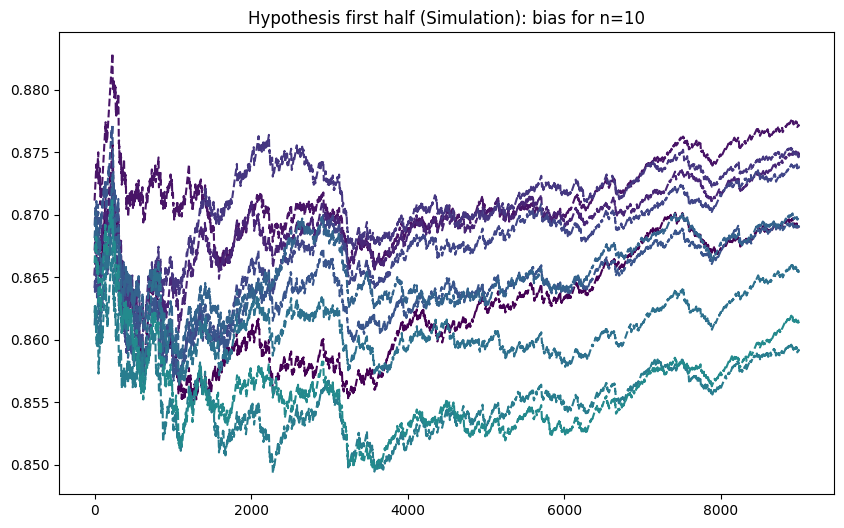

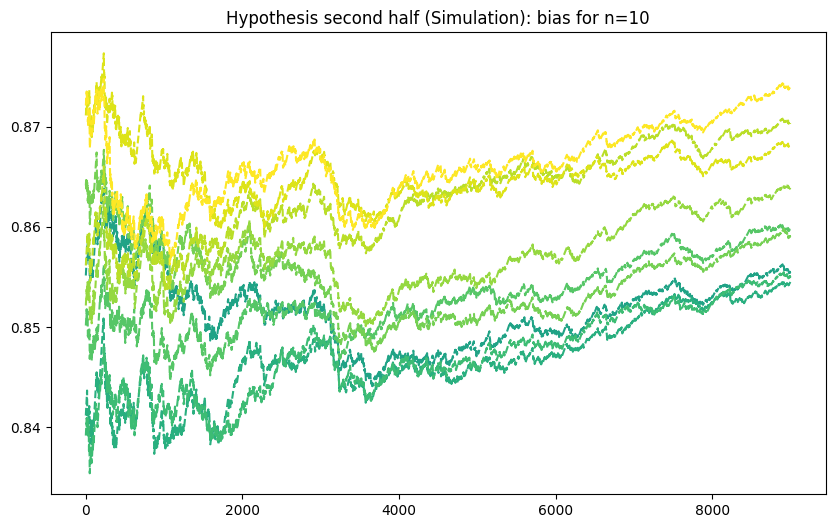

In [13]:
from matplotlib import cm
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)




# Compute biases for all points on the circle
bias_for = []
bias_for_ml = []
burn = 1000
for idx in range(num_points):

    logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
    likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

    bias_for_values = logBR_prior_pd_values > 0
    bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

    mu_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]
    y_samples = idata.posterior[f'yl_{idx}'].values
    marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
    bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

    bias_for.append(bias_for_mci)
    bias_for_ml.append(bias_for_ml_mci)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Color Gradient")
plt.yticks([])
plt.show()


# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the circle and the true parameter values
# Generate points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
x = beta0[0] + delta * np.cos(theta)
y = beta0[1] + delta * np.sin(theta)
plt.figure(figsize=(8, 8))
plt.plot(x, y, label='Circle of radius delta')
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')

# Plotting the points with corresponding colors
circle_points = np.column_stack((x, y))
for idx in range(num_points):
    plt.scatter(circle_points[idx, 0], circle_points[idx, 1], color=colors[idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Circle')
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Simulation): bias for n={}".format(n))
plt.show()


# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])


plt.title("Hypothesis second half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Simulation): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis second half (Simulation): bias for n={}".format(n))
plt.show()

Rhombus

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

# Function to calculate Bezier curve points
def bezier_curve(control_points, num_points=100):
    n = len(control_points) - 1
    curve = np.zeros((num_points, 2))
    t = np.linspace(0, 1, num_points)
    for i in range(n + 1):
        curve += np.outer(binom(n, i) * (t ** i) * ((1 - t) ** (n - i)), control_points[i])
    return curve

# True parameter values
beta0 = np.array([1, 2])
delta = 0.05  # Half-diagonal length of the rhombus

# Define the four vertices of the rhombus
vertices = np.array([
    [beta0[0] + delta, beta0[1]],  # Right vertex
    [beta0[0], beta0[1] + delta],  # Top vertex
    [beta0[0] - delta, beta0[1]],  # Left vertex
    [beta0[0], beta0[1] - delta]   # Bottom vertex
])

# Define control points for inward-curving sides
control_points = []
control_points.append([vertices[1], beta0, vertices[2]])  # Top to Left
control_points.append([vertices[2], beta0, vertices[3]])  # Left to Bottom
control_points.append([vertices[3], beta0, vertices[0]])  # Bottom to Right
control_points.append([vertices[0], beta0, vertices[1]])  # Right to Top

# Generate points on the inward-curving rhombus
num_points_per_curve = 6
curved_points = []
for cp in control_points:
    curve = bezier_curve(cp, num_points_per_curve)
    curved_points.append(curve)

# Concatenate all points
curved_rhombus_points = np.vstack(curved_points)


In [ ]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 20  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
mu0 = np.dot(X, beta0)
delta = 0.05
sigma0 = 1

num_points = len(curved_rhombus_points)

# Vectorized response variable generation
muls = np.dot(X, curved_rhombus_points.T).T  # Shape: (25, n)
yls = muls + np.random.normal(0, sigma0, (num_points, n))  # Shape: (25, n)

start_time = time.time()

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov = (mu_prior_sigma**2) * np.eye(p), shape=p)
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    mu = pm.Deterministic("mu", pm.math.dot(X, beta))

    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    # Iterate over each point on the circle
    for i, betal in enumerate(curved_rhombus_points):
        # Likelihood
        mu_l = np.dot(X, betal)
        yl_ = pm.MvNormal(f'yl_{i}', mu=mu_l, cov=(sigma0**2) * np.eye(n), shape=n)

        # Prior for beta at each point
        prior_pd = pm.Deterministic(f'prior_pd_{i}', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta0))

        #Lower
        mean_betal = pm.Deterministic(f'mean_betal_{i}', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yl_)) + np.dot(Sigma_beta_inv, betal)))
        posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mean_betal, cov=cov_beta_post, shape=p), beta0))

        # Log BR
        logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - prior_pd)


        # Likelihood
        likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Cell execution time: {elapsed_time:.2f} seconds")


In [ ]:
from matplotlib import cm
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)




# Compute biases for all points on the circle
bias_for = []
bias_for_ml = []
burn = 1000
for idx in range(num_points):
    if idx == 0:
        print(idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel())
        print(idata.posterior[f'prior_pd_{idx}'].values.ravel())
        print(idata.posterior[f'posterior_pdl_{idx}'].values.ravel())

    logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
    likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

    bias_for_values = logBR_prior_pd_values > 0
    bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

    mu_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]
    y_samples = idata.posterior[f'yl_{idx}'].values
    marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
    bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

    bias_for.append(bias_for_mci)
    bias_for_ml.append(bias_for_ml_mci)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Color Gradient")
plt.yticks([])
plt.show()


# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the circle and the true parameter values
plt.figure(figsize=(8, 8))
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')


for idx in range(num_points):
    plt.scatter(curved_rhombus_points[idx, 0], curved_rhombus_points[idx, 1], color=colors[idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Inward Rhombus')
plt.show()


# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Simulation): bias for n={}".format(n))
plt.show()


# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])


plt.title("Hypothesis second half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Simulation): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis second half (Simulation): bias for n={}".format(n))
plt.show()

Rough work

In [ ]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 20  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
mu0 = np.dot(X, beta0)
delta = 0.05
sigma0 = 1

# Generate points on the circle
num_points = 15  # Number of points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
circle_points = np.column_stack((beta0[0] + delta * np.cos(theta), beta0[1] + delta * np.sin(theta)))

num_points = len(circle_points)

# Vectorized response variable generation
muls = np.dot(X, circle_points.T).T  # Shape: (num_points, n)
yls = muls + np.random.normal(0, sigma0, (num_points, n))  # Shape: (num_points, n)

start_time = time.time()
print(circle_points)
with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov = (mu_prior_sigma**2) * np.eye(p), shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    mu = pm.Deterministic("mu", pm.math.dot(X, beta))

    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    # Iterate over each point on the circle
    for i, betal in enumerate(circle_points):
        # Likelihood
        y_l = pm.MvNormal(f'y_l_{i}', mu=muls[i], cov=(sigma0**2) * np.eye(n), shape=n)

        # Prior for beta at each point
        prior_beta = pm.MvNormal(f'prior_beta_{i}', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p))

        # Prior predictive log-likelihood
        prior_mu = pm.math.dot(X, prior_beta)
        prior_pdl = pm.Deterministic(f'prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=prior_mu, cov=np.eye(n), shape = n), mu))

        # Posterior mean and covariance for beta
        mean_beta_post = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yls[i])) + np.dot(Sigma_beta_inv, beta0))

        # Posterior distribution for beta at each point
        posterior_beta = pm.MvNormal(f'posterior_beta_{i}', mu=mean_beta_post, cov=cov_beta_post)

        # Posterior predictive log-likelihood
        posterior_mu = pm.math.dot(X, posterior_beta)
        posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=posterior_mu, cov=np.eye(n), shape = n), mu))

        # Log BR
        logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - prior_pdl)

        # Likelihood
        likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=n), yls[i]).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Cell execution time: {elapsed_time:.2f} seconds")


[[1.05       2.        ]
 [1.04504844 2.02169419]
 [1.03117449 2.03909157]
 [1.01112605 2.0487464 ]
 [0.98887395 2.0487464 ]
 [0.96882551 2.03909157]
 [0.95495156 2.02169419]
 [0.95       2.        ]
 [0.95495156 1.97830581]
 [0.96882551 1.96090843]
 [0.98887395 1.9512536 ]
 [1.01112605 1.9512536 ]
 [1.03117449 1.96090843]
 [1.04504844 1.97830581]
 [1.05       2.        ]]


Cell execution time: 1799.64 seconds


[  7.75801087  -6.43573594   2.39888526 ... 160.12170887  27.9034765
   9.43397588]
[ -41.43435088  -35.35651171  -37.52886648 ... -191.49797994  -56.03684759
  -33.10915236]
[-33.67634001 -41.79224765 -35.12998122 ... -31.37627107 -28.13337109
 -23.67517649]


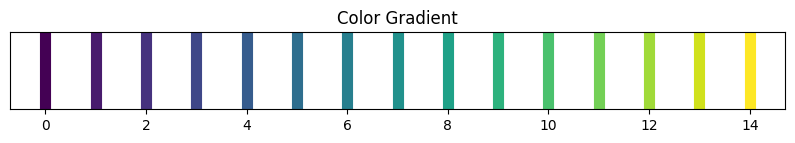

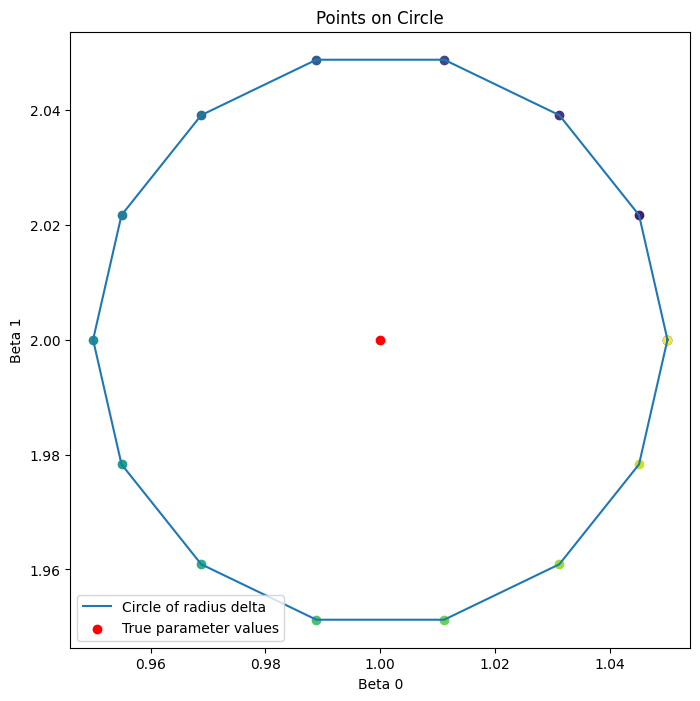

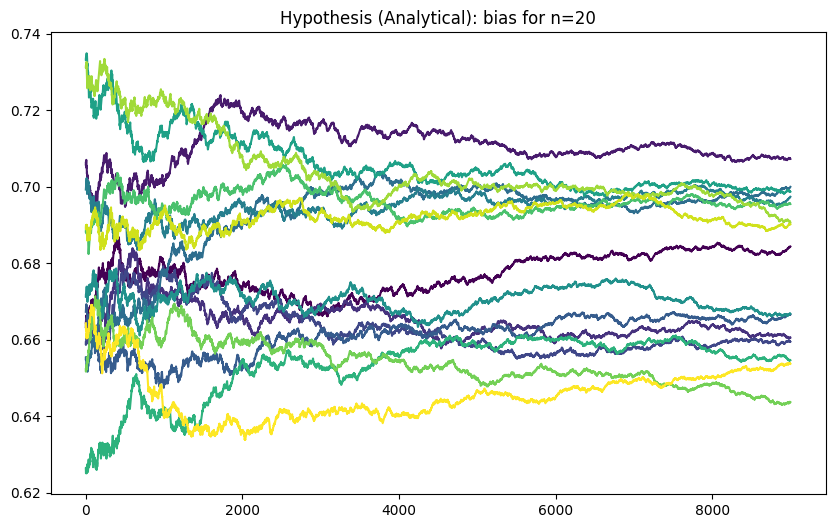

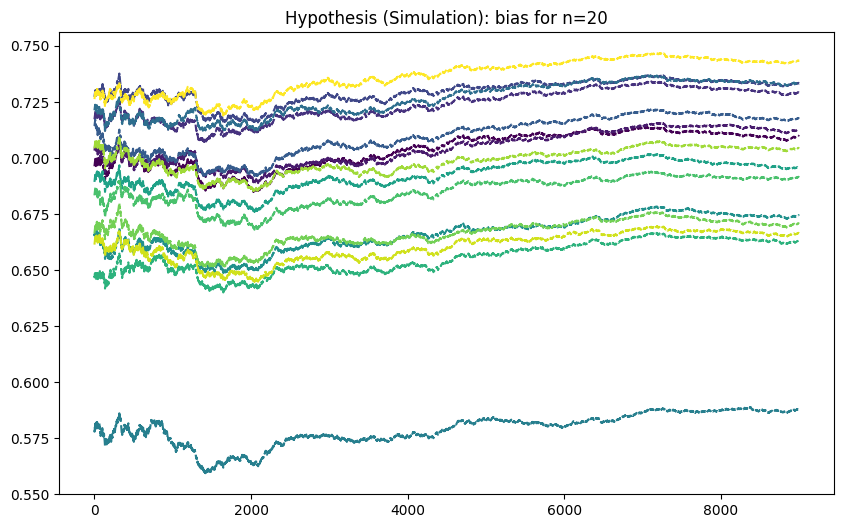

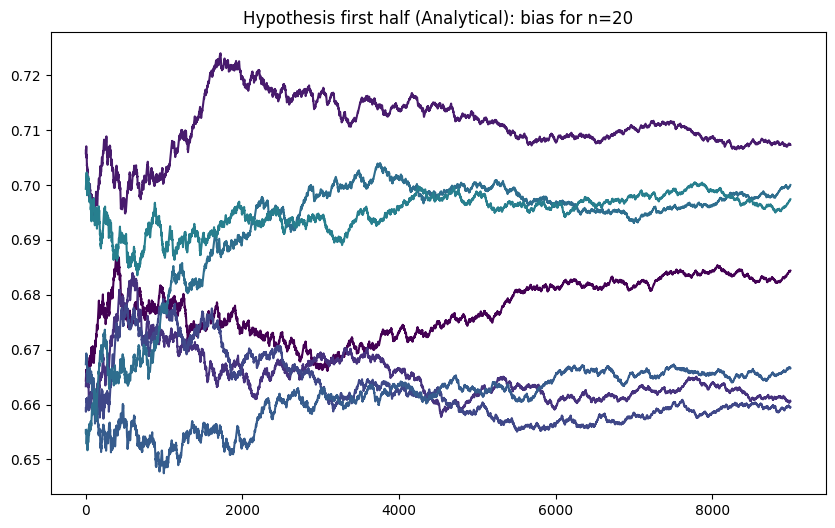

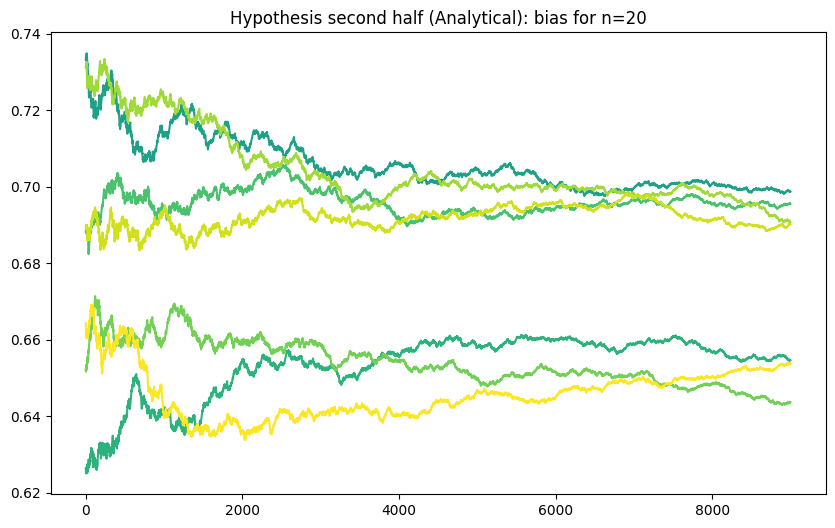

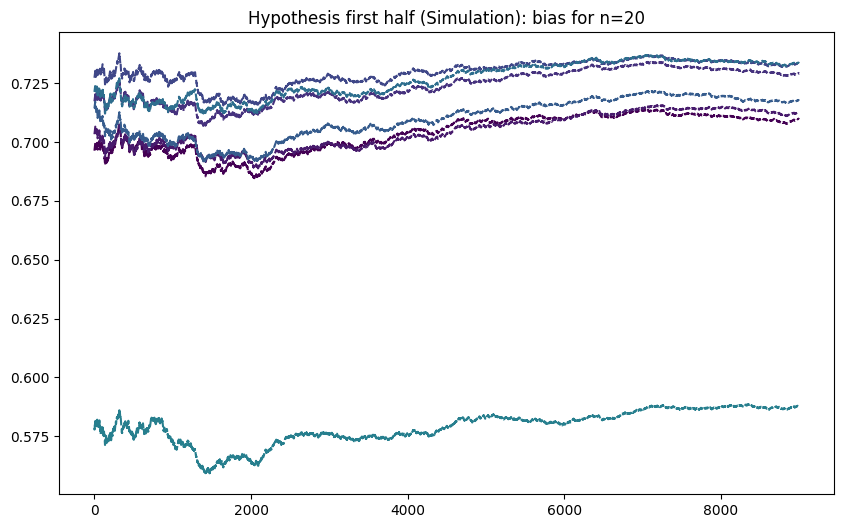

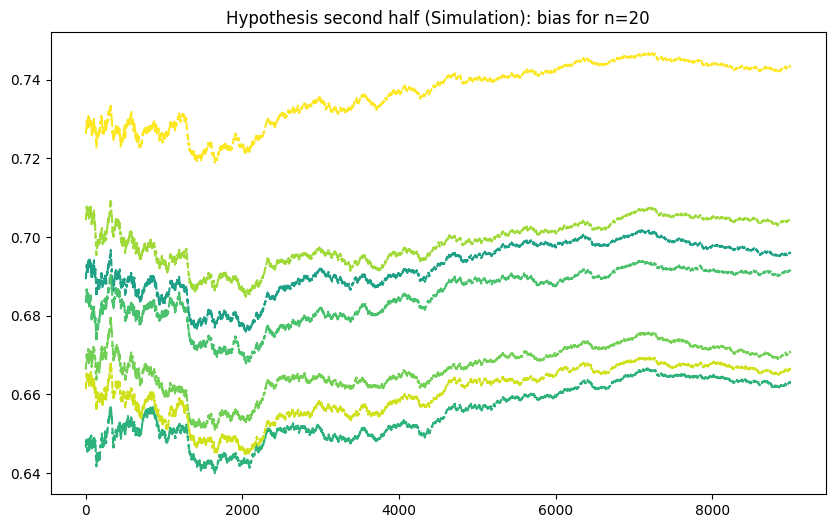

In [ ]:
from matplotlib import cm
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)


# Compute biases for all points on the circle
bias_for = []
bias_for_ml = []
burn = 1000
for idx in range(num_points):
    if idx == 0:
        print(idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel())
        print(idata.posterior[f'prior_pdl_{idx}'].values.ravel())
        print(idata.posterior[f'posterior_pdl_{idx}'].values.ravel())

    logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
    likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

    bias_for_values = logBR_prior_pd_values > 0
    bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

    mu_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]
    y_samples = idata.posterior[f'y_l_{idx}'].values
    marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
    bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

    bias_for.append(bias_for_mci)
    bias_for_ml.append(bias_for_ml_mci)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Color Gradient")
plt.yticks([])
plt.show()


# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the circle and the true parameter values
# Generate points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
x = beta0[0] + delta * np.cos(theta)
y = beta0[1] + delta * np.sin(theta)
plt.figure(figsize=(8, 8))
plt.plot(x, y, label='Circle of radius delta')
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')

# Plotting the points with corresponding colors
circle_points = np.column_stack((x, y))
for idx in range(num_points):
    plt.scatter(circle_points[idx, 0], circle_points[idx, 1], color=colors[idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Circle')
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Simulation): bias for n={}".format(n))
plt.show()


# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])


plt.title("Hypothesis second half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Simulation): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis second half (Simulation): bias for n={}".format(n))
plt.show()

CURVEDD RHOMBUS

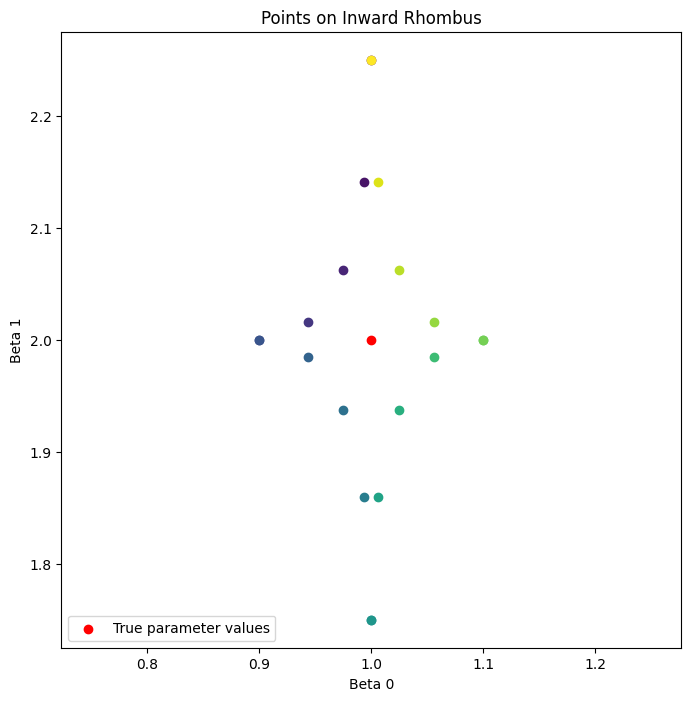

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom
from matplotlib import cm

# Function to calculate Bezier curve points
def bezier_curve(control_points, num_points=100):
    n = len(control_points) - 1
    curve = np.zeros((num_points, 2))
    t = np.linspace(0, 1, num_points)
    for i in range(n + 1):
        curve += np.outer(binom(n, i) * (t ** i) * ((1 - t) ** (n - i)), control_points[i])
    return curve

# True parameter values
beta0 = np.array([1, 2])
delta0 = 0.1  # Half-diagonal length of the rhombus
delta1 = 0.25

# Define the four vertices of the rhombus
vertices = np.array([
    [beta0[0] + delta0, beta0[1]],  # Right vertex
    [beta0[0], beta0[1] + delta1],  # Top vertex
    [beta0[0] - delta0, beta0[1]],  # Left vertex
    [beta0[0], beta0[1] - delta1]   # Bottom vertex
])

# Define control points for inward-curving sides
control_points = []
control_points.append([vertices[1], beta0, vertices[2]])  # Top to Left
control_points.append([vertices[2], beta0, vertices[3]])  # Left to Bottom
control_points.append([vertices[3], beta0, vertices[0]])  # Bottom to Right
control_points.append([vertices[0], beta0, vertices[1]])  # Right to Top

# Generate points on the inward-curving rhombus
num_points_per_curve = 5
curved_points = []
for cp in control_points:
    curve = bezier_curve(cp, num_points_per_curve)
    curved_points.append(curve)

# Concatenate all points
curved_rhombus_points = np.vstack(curved_points)
num_points = len(curved_rhombus_points)
# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the circle and the true parameter values
plt.figure(figsize=(8, 8))
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')
num_points = len(curved_rhombus_points)

for idx in range(num_points):
    plt.scatter(curved_rhombus_points[idx, 0], curved_rhombus_points[idx, 1], color=colors[idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Inward Rhombus')
plt.show()

In [ ]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 20  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
mu0 = np.dot(X, beta0)
delta = 0.05
sigma0 = 1

num_points = len(curved_rhombus_points)

# Vectorized response variable generation
muls = np.dot(X, curved_rhombus_points.T).T  # Shape: (num_points, n)
yls = muls + np.random.normal(0, sigma0, (num_points, n))  # Shape: (num_points, n)

start_time = time.time()
print(curved_rhombus_points)
with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov = (mu_prior_sigma**2) * np.eye(p), shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    mu = pm.Deterministic("mu", pm.math.dot(X, beta))

    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    # Iterate over each point on the curved_rhombus
    for i, betal in enumerate(curved_rhombus_points):
        # Likelihood
        y_l = pm.MvNormal(f'y_l_{i}', mu=muls[i], cov=(sigma0**2) * np.eye(n), shape=n)

        # Prior for beta at each point
        prior_beta = pm.MvNormal(f'prior_beta_{i}', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p))

        # Prior predictive log-likelihood
        prior_mu = pm.math.dot(X, prior_beta)
        prior_pdl = pm.Deterministic(f'prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=prior_mu, cov=np.eye(n), shape = n), mu))

        # Posterior mean and covariance for beta
        mean_beta_post = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yls[i])) + np.dot(Sigma_beta_inv, beta0))

        # Posterior distribution for beta at each point
        posterior_beta = pm.MvNormal(f'posterior_beta_{i}', mu=mean_beta_post, cov=cov_beta_post)

        # Posterior predictive log-likelihood
        posterior_mu = pm.math.dot(X, posterior_beta)
        posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=posterior_mu, cov=np.eye(n), shape = n), mu))

        # Log BR
        logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - prior_pdl)

        # Likelihood
        likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=n), y_l).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Cell execution time: {elapsed_time:.2f} seconds")




[[1.       2.25    ]
 [0.99375  2.140625]
 [0.975    2.0625  ]
 [0.94375  2.015625]
 [0.9      2.      ]
 [0.9      2.      ]
 [0.94375  1.984375]
 [0.975    1.9375  ]
 [0.99375  1.859375]
 [1.       1.75    ]
 [1.       1.75    ]
 [1.00625  1.859375]
 [1.025    1.9375  ]
 [1.05625  1.984375]
 [1.1      2.      ]
 [1.1      2.      ]
 [1.05625  2.015625]
 [1.025    2.0625  ]
 [1.00625  2.140625]
 [1.       2.25    ]]


Cell execution time: 5848.33 seconds


[ 32.68542914 -14.62726275   5.21625008 ...  -8.44271634  37.83656535
  53.779289  ]
[-60.80341863 -18.98731474 -27.44397305 ... -44.99792125 -62.6179403
 -89.45864761]
[-28.11798949 -33.6145775  -22.22772297 ... -53.44063759 -24.78137495
 -35.67935861]


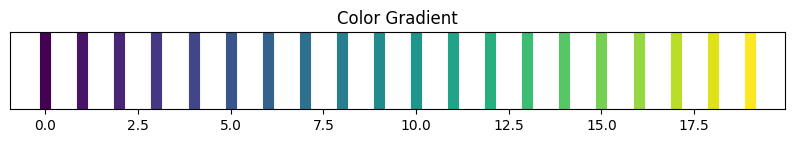

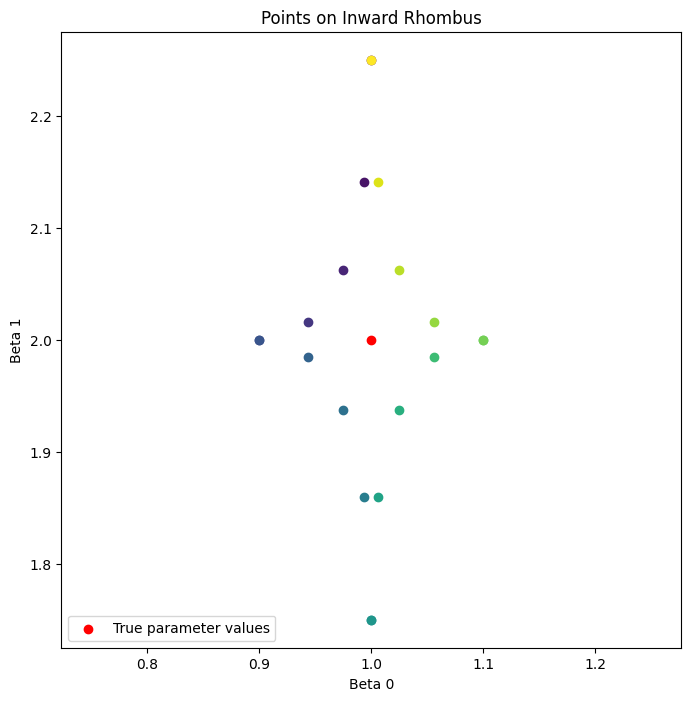

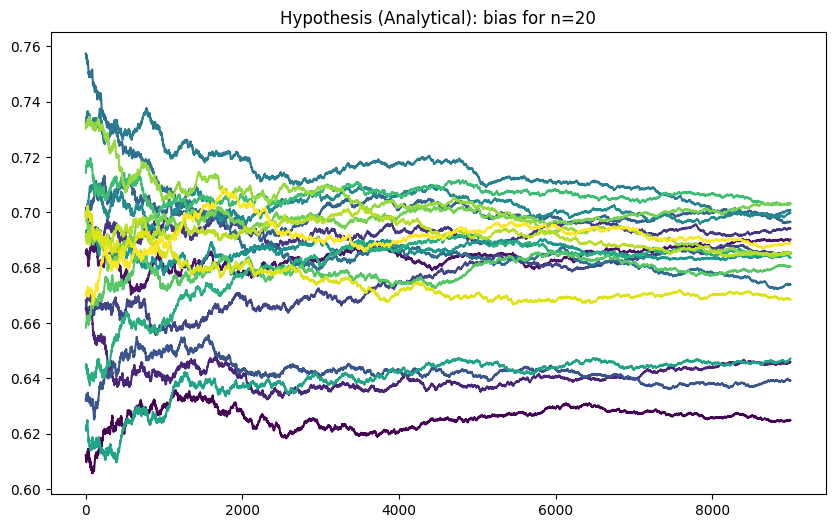

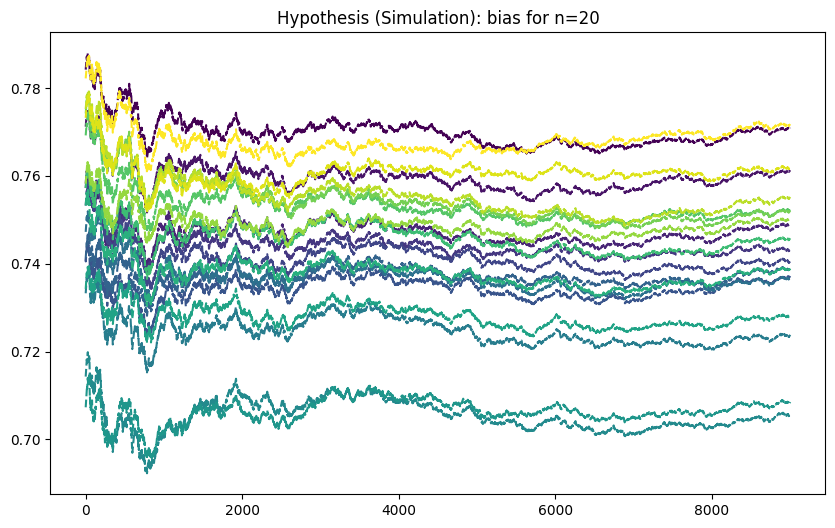

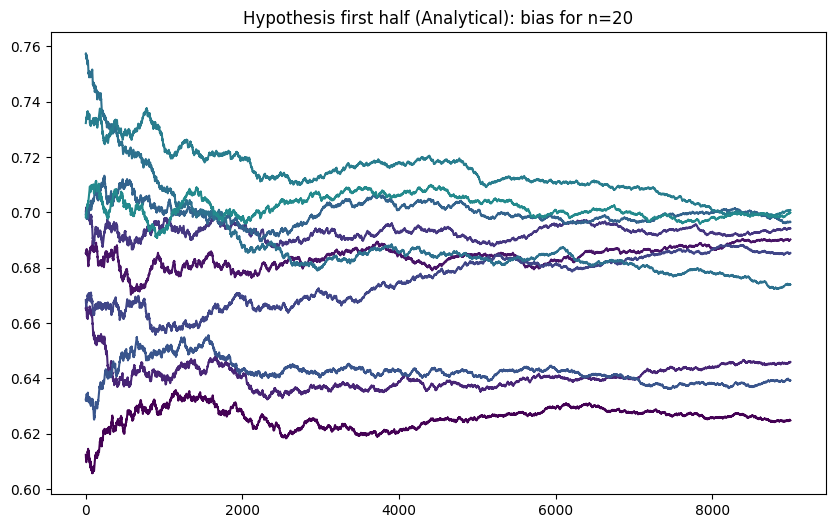

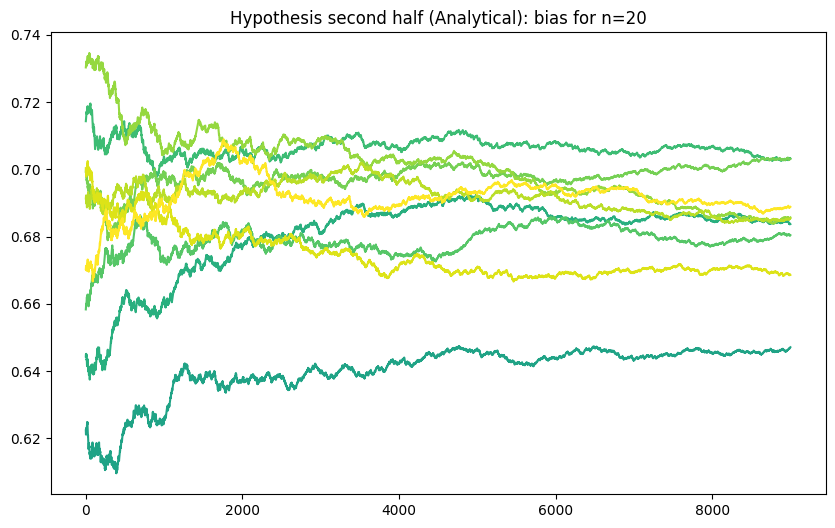

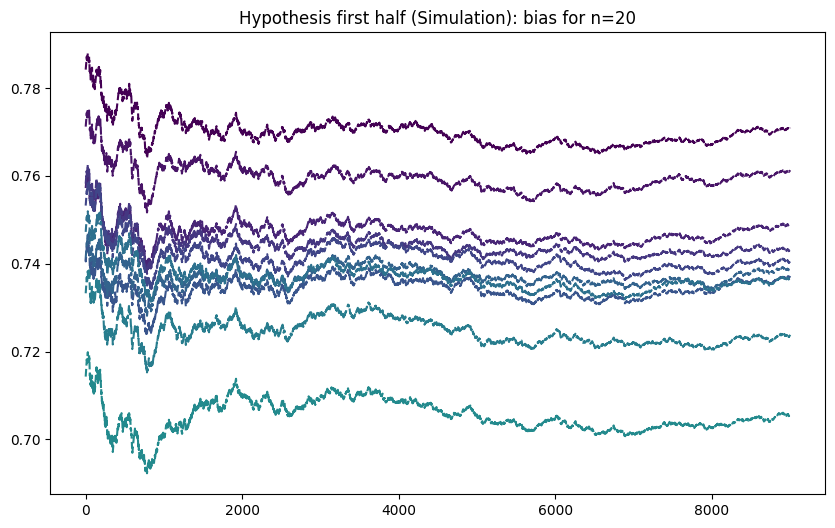

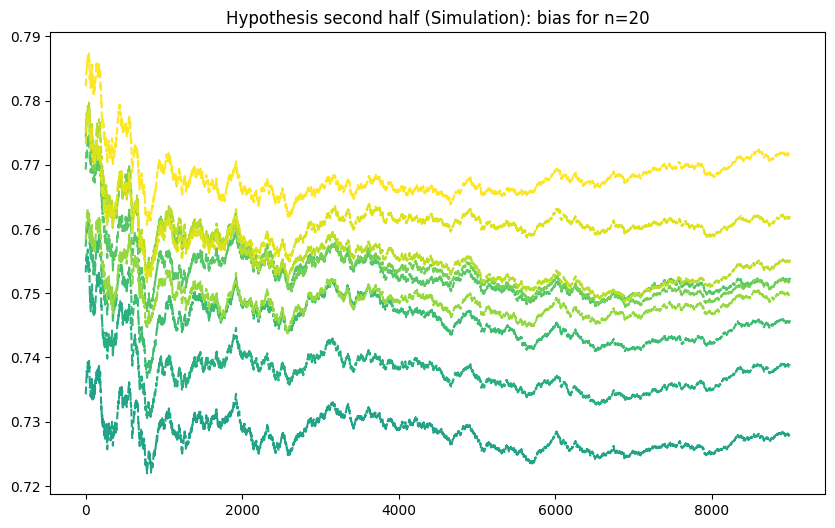

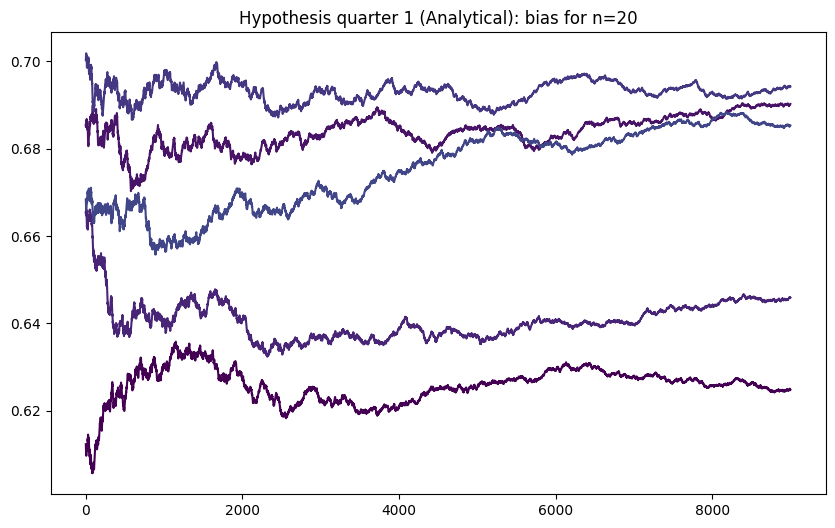

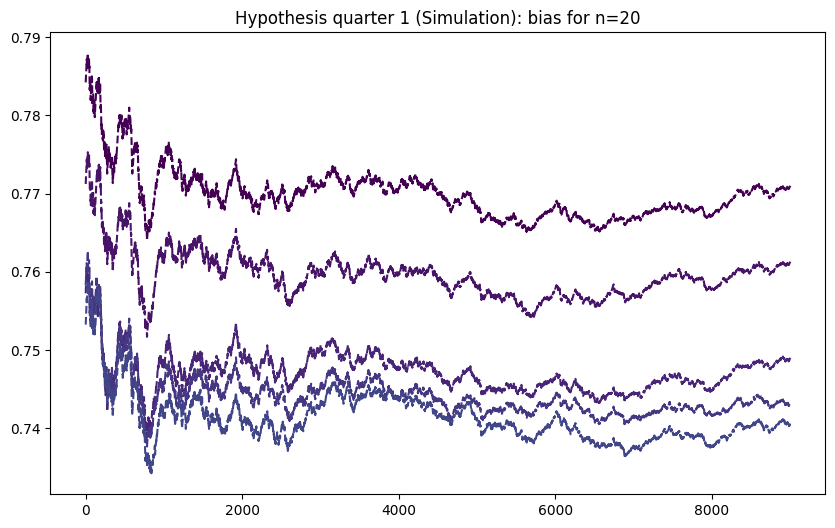

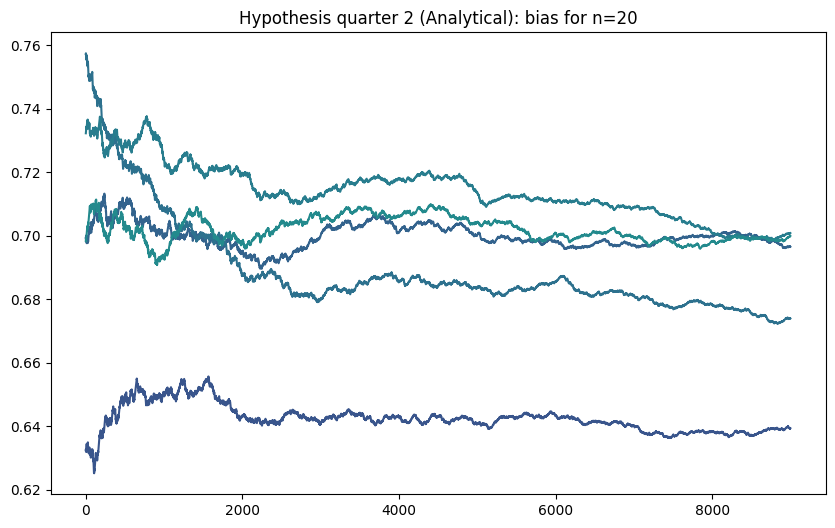

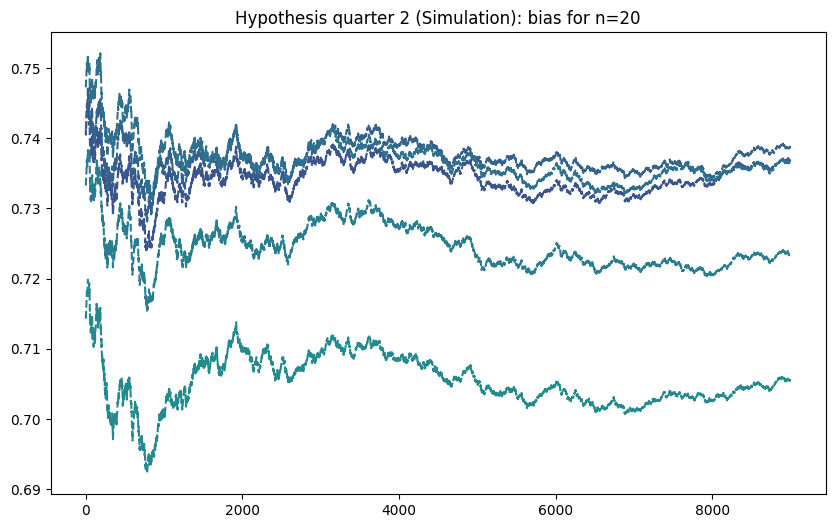

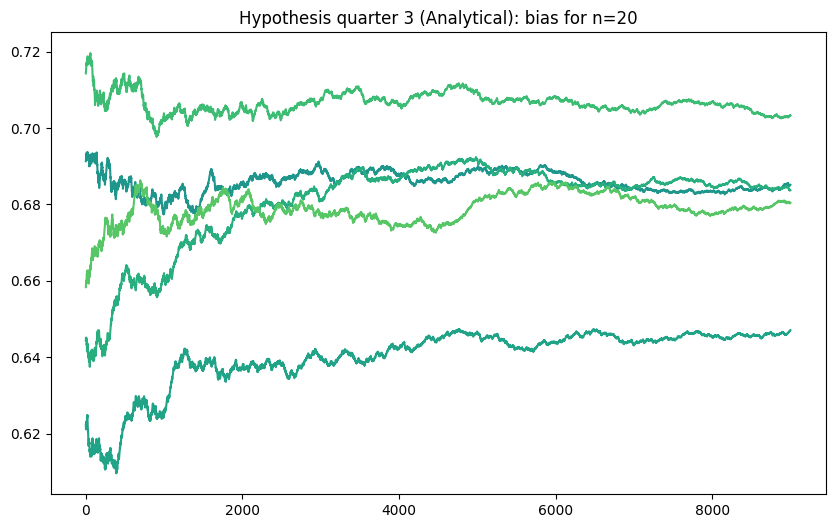

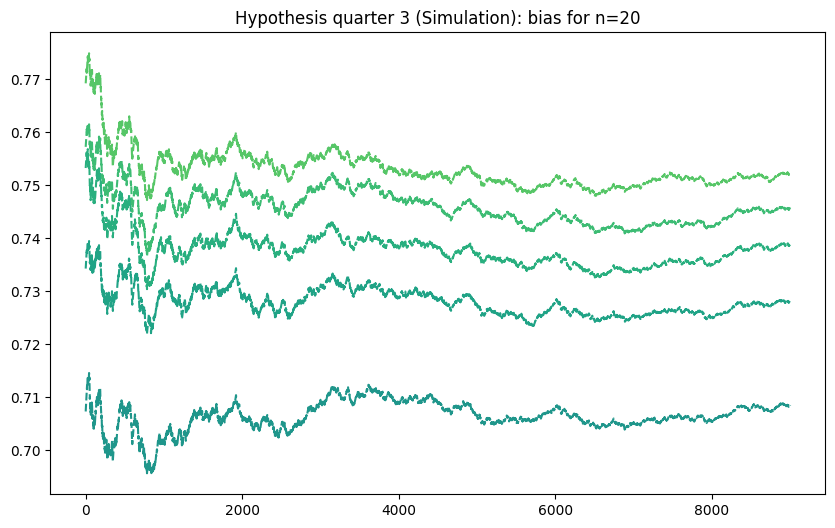

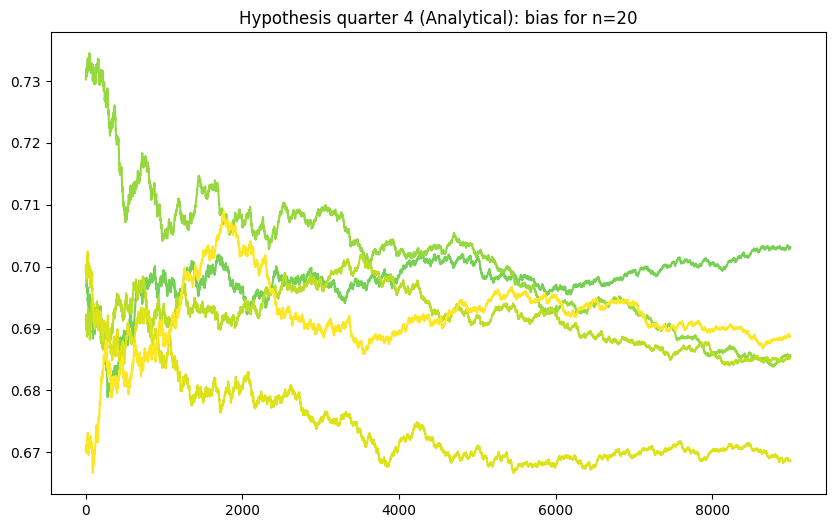

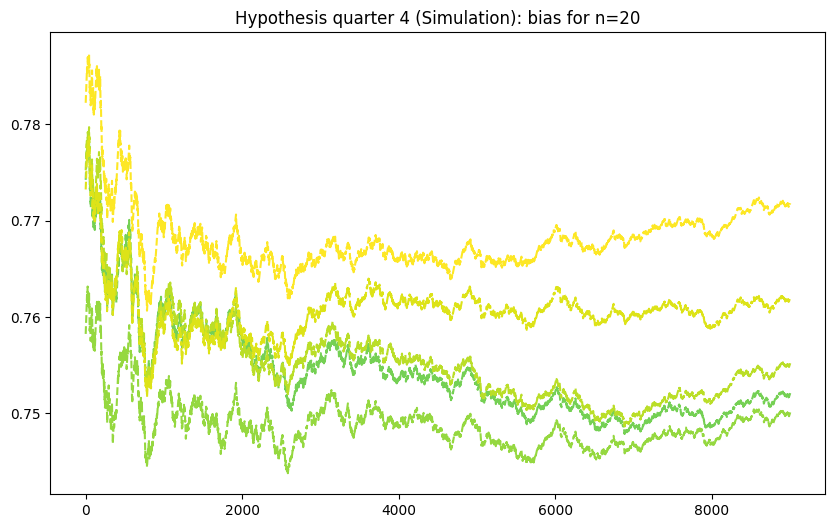

In [ ]:
from matplotlib import cm

def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

# Compute biases for all points on the circle
bias_for = []
bias_for_ml = []
burn = 1000
for idx in range(num_points):
    if idx == 0:
        print(idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel())
        print(idata.posterior[f'prior_pdl_{idx}'].values.ravel())
        print(idata.posterior[f'posterior_pdl_{idx}'].values.ravel())

    logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
    likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

    bias_for_values = logBR_prior_pd_values > 0
    bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

    mu_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]
    y_samples = idata.posterior[f'y_l_{idx}'].values
    marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
    bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

    bias_for.append(bias_for_mci)
    bias_for_ml.append(bias_for_ml_mci)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Color Gradient")
plt.yticks([])
plt.show()

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the circle and the true parameter values
plt.figure(figsize=(8, 8))
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')


for idx in range(num_points):
    plt.scatter(curved_rhombus_points[idx, 0], curved_rhombus_points[idx, 1], color=colors[idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Inward Rhombus')
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Simulation): bias for n={}".format(n))
plt.show()

# Plotting first half
plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])

plt.title("Hypothesis second half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Simulation): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis second half (Simulation): bias for n={}".format(n))
plt.show()

# Plotting quarters
quarters = [(0, num_points//4), (num_points//4, num_points//2),
            (num_points//2, 3*num_points//4), (3*num_points//4, num_points)]

for q, (start, end) in enumerate(quarters):
    plt.figure(figsize=(10, 6))
    for idx in range(start, end):
        plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.title(f"Hypothesis quarter {q+1} (Analytical): bias for n={n}")
    plt.show()

    plt.figure(figsize=(10, 6))
    for idx in range(start, end):
        plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])
    plt.title(f"Hypothesis quarter {q+1} (Simulation): bias for n={n}")
    plt.show()


[ 19.18149814 -11.2743769   15.2274879  ...  15.32465768  60.82513216
 -22.95696247]
[-48.20737466 -54.59771436 -36.40197945 ... -66.68422102 -82.04535326
 -33.05754712]
[-29.02587652 -65.87209126 -21.17449156 ... -51.35956334 -21.2202211
 -56.01450959]


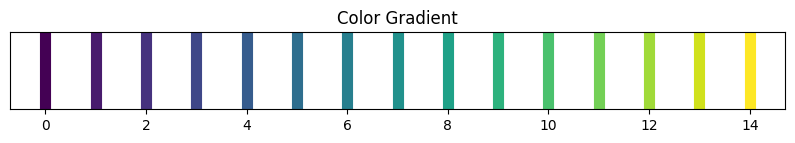

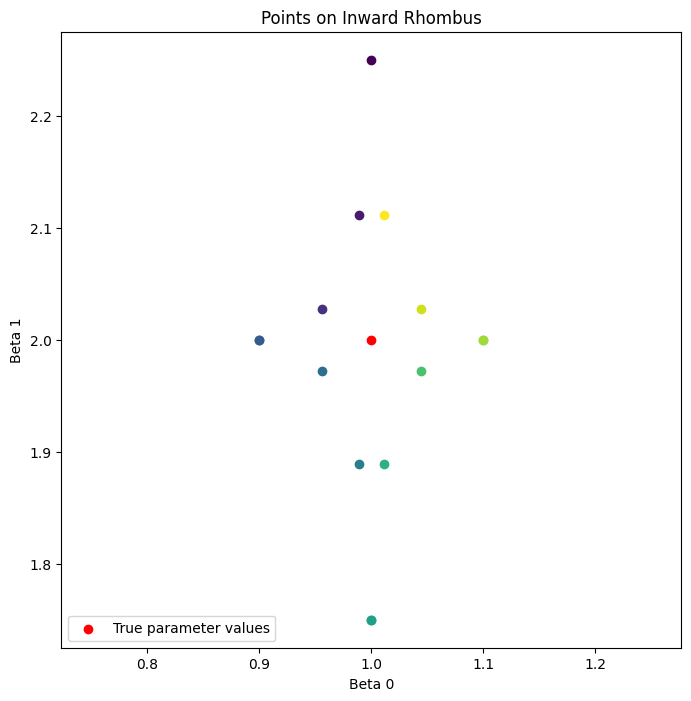

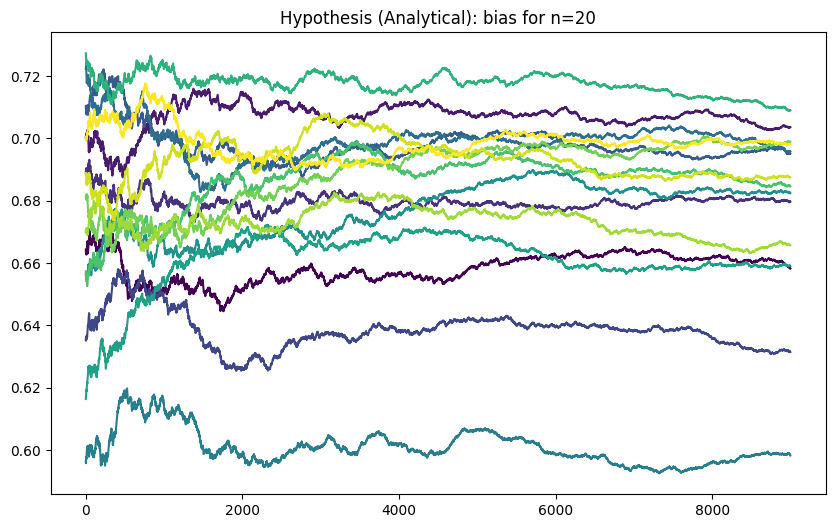

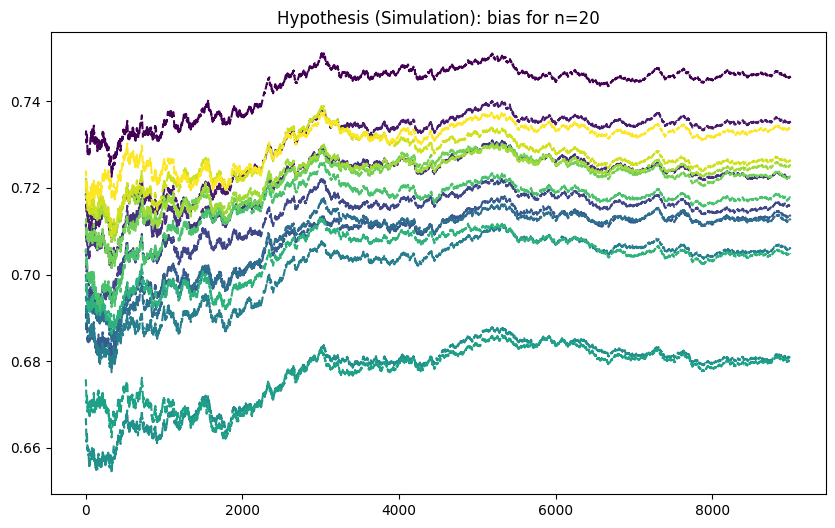

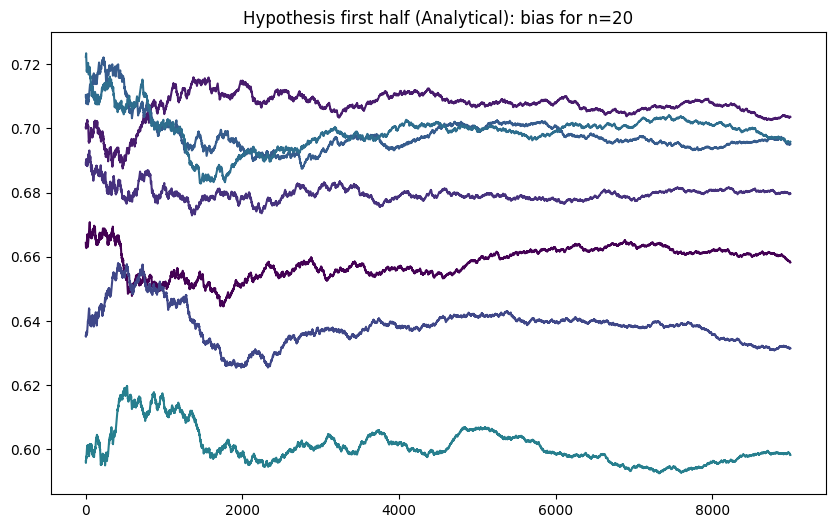

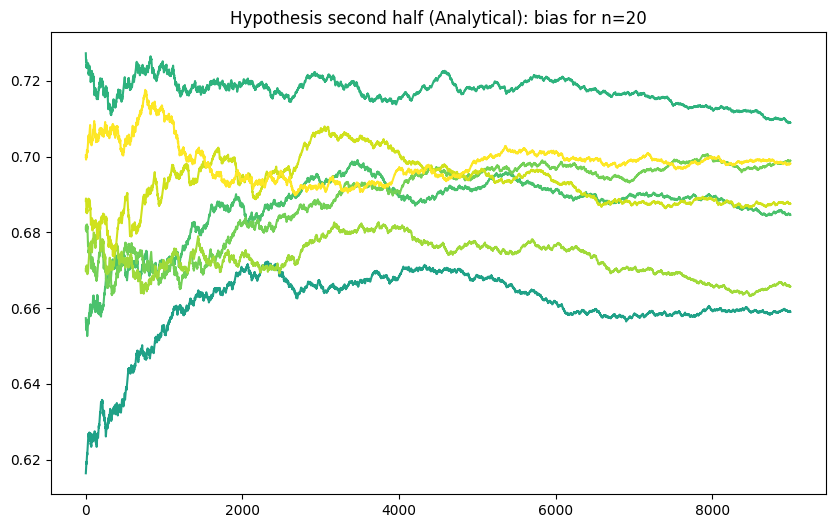

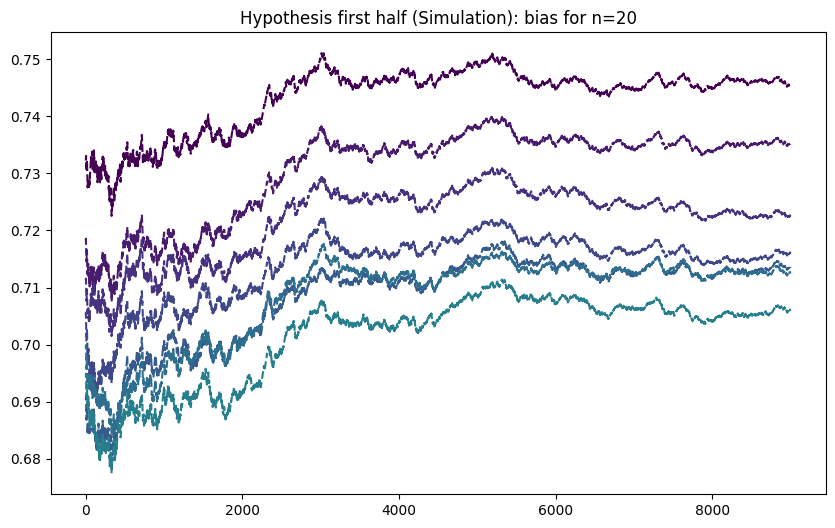

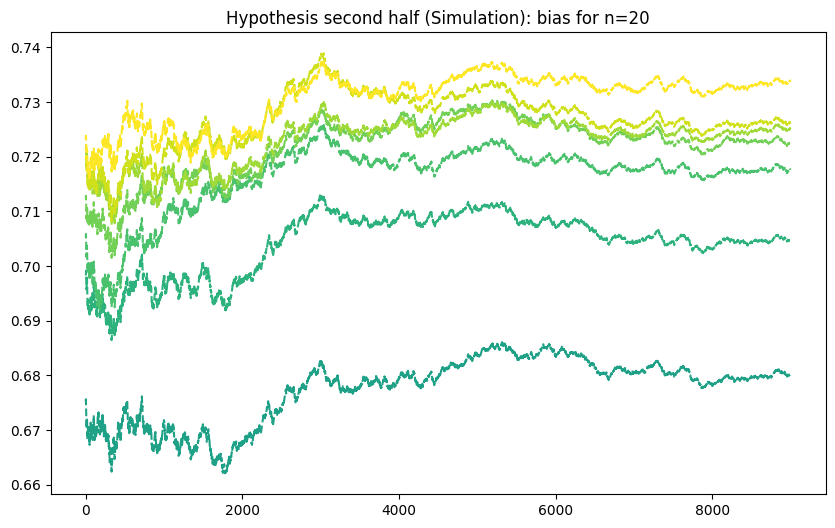

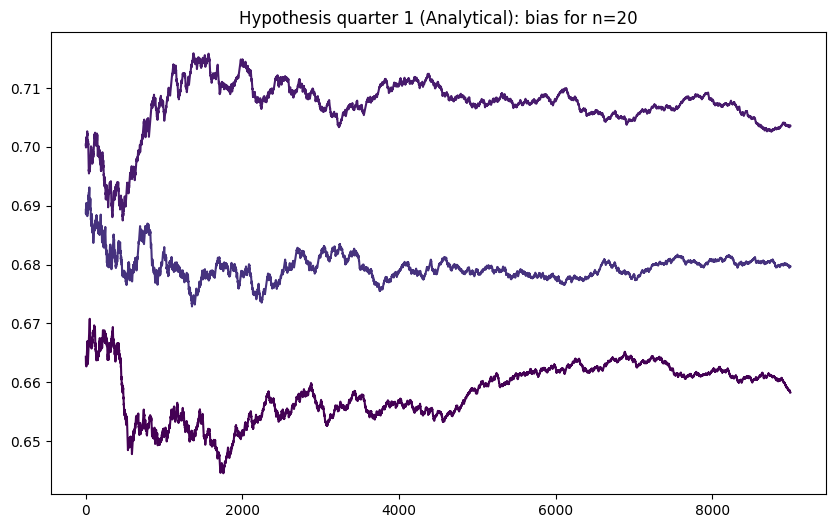

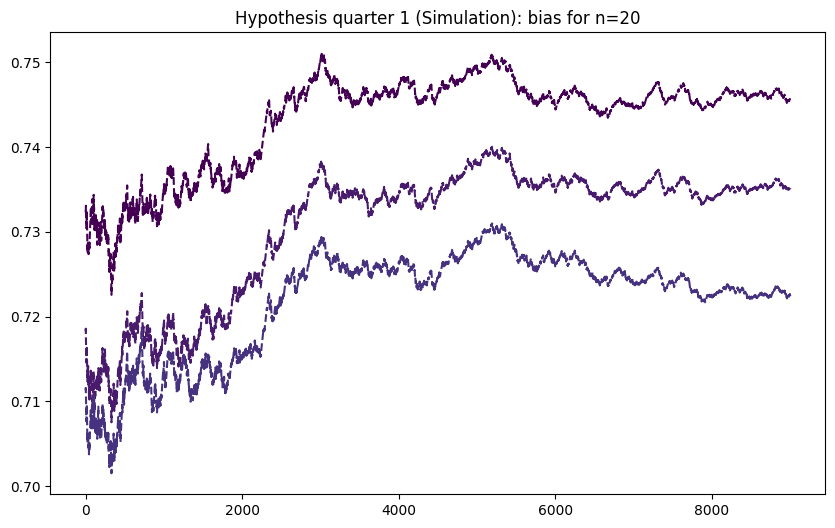

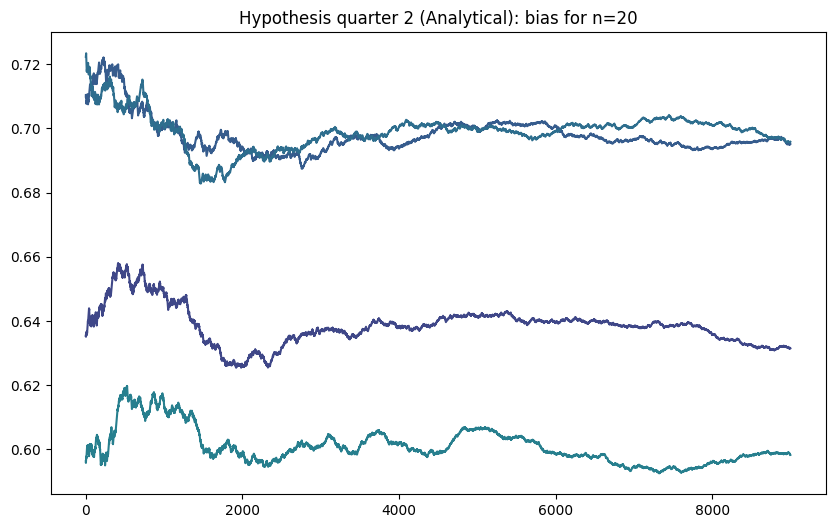

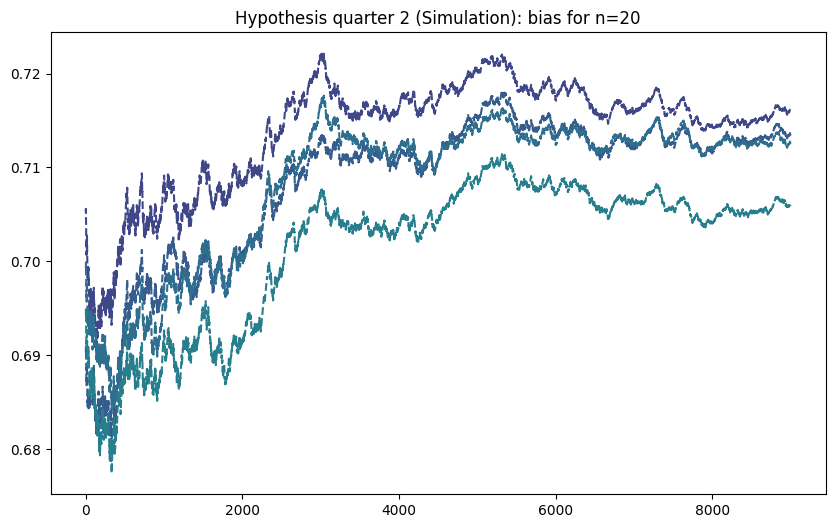

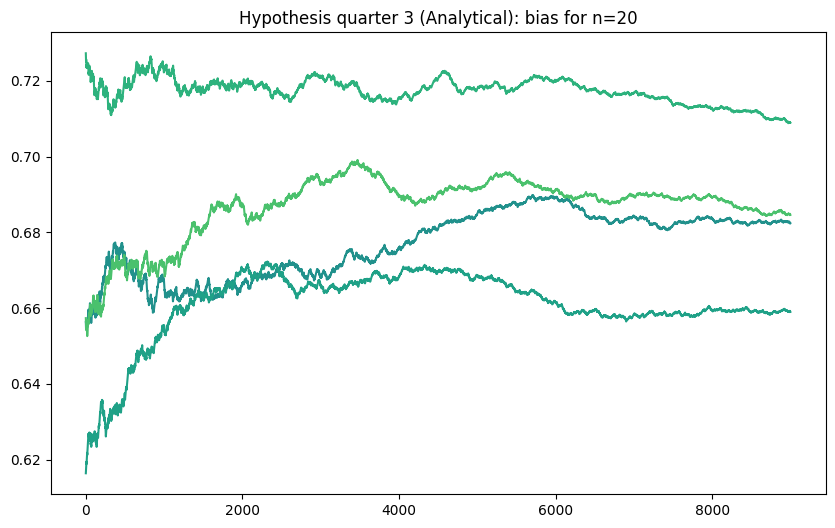

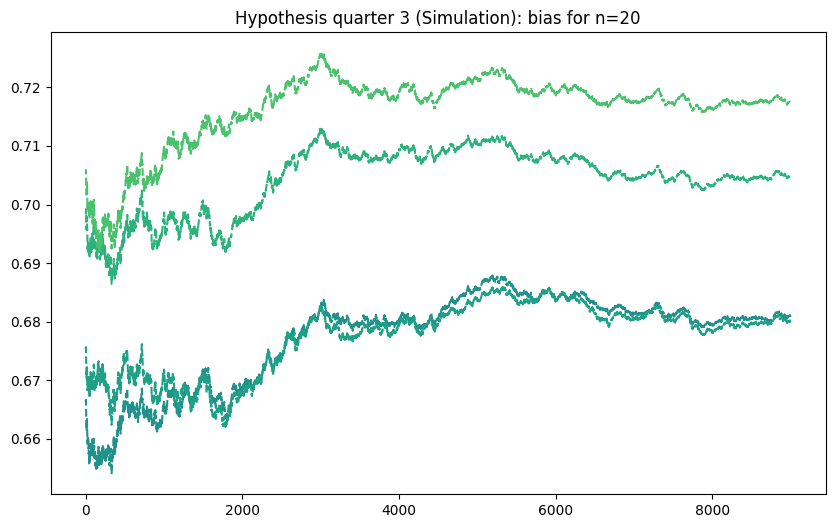

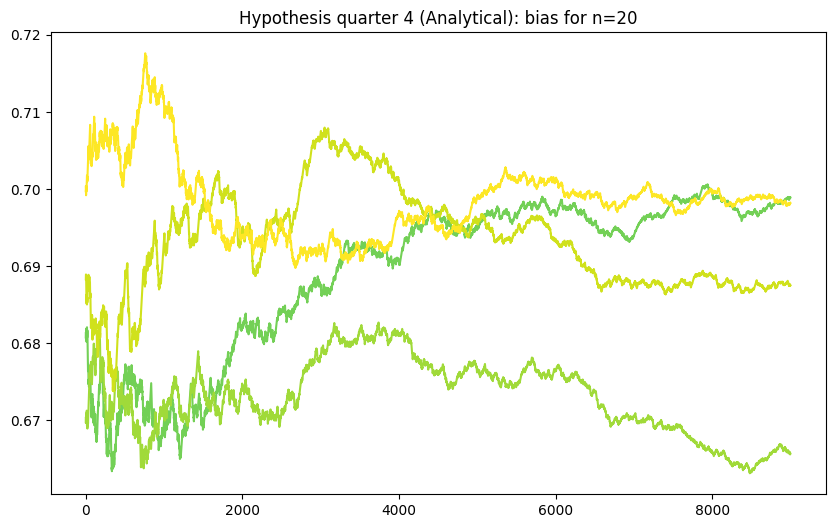

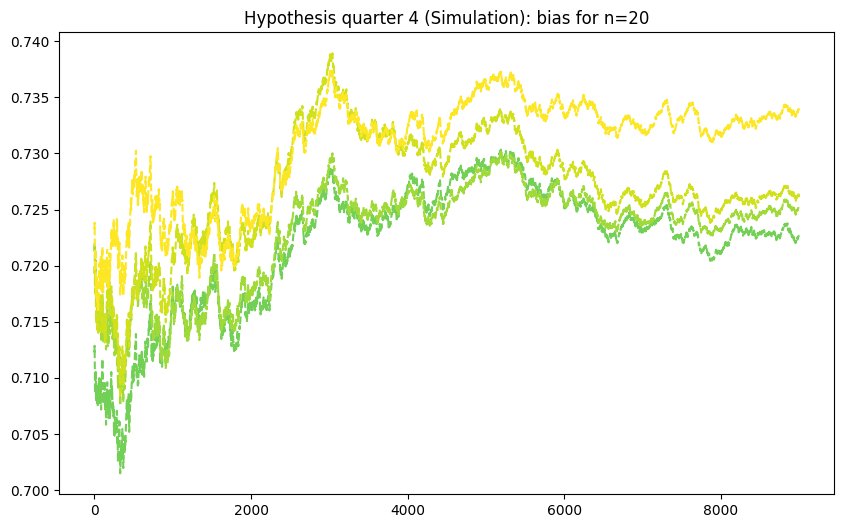

In [ ]:
from matplotlib import cm

def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

# Compute biases for all points on the circle
bias_for = []
bias_for_ml = []
burn = 1000
for idx in range(num_points):
    if idx == 0:
        print(idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel())
        print(idata.posterior[f'prior_pdl_{idx}'].values.ravel())
        print(idata.posterior[f'posterior_pdl_{idx}'].values.ravel())

    logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
    likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

    bias_for_values = logBR_prior_pd_values > 0
    bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

    mu_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]
    y_samples = idata.posterior[f'y_l_{idx}'].values
    marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
    bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

    bias_for.append(bias_for_mci)
    bias_for_ml.append(bias_for_ml_mci)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Color Gradient")
plt.yticks([])
plt.show()

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the circle and the true parameter values
plt.figure(figsize=(8, 8))
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')


for idx in range(num_points):
    plt.scatter(curved_rhombus_points[idx, 0], curved_rhombus_points[idx, 1], color=colors[idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Inward Rhombus')
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Simulation): bias for n={}".format(n))
plt.show()

# Plotting first half
plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])

plt.title("Hypothesis second half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Simulation): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis second half (Simulation): bias for n={}".format(n))
plt.show()

# Plotting quarters
quarters = [(0, num_points//4), (num_points//4, num_points//2),
            (num_points//2, 3*num_points//4), (3*num_points//4, num_points)]

for q, (start, end) in enumerate(quarters):
    plt.figure(figsize=(10, 6))
    for idx in range(start, end):
        plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.title(f"Hypothesis quarter {q+1} (Analytical): bias for n={n}")
    plt.show()

    plt.figure(figsize=(10, 6))
    for idx in range(start, end):
        plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])
    plt.title(f"Hypothesis quarter {q+1} (Simulation): bias for n={n}")
    plt.show()


Bias Against

In [10]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 20  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    # Likelihood
    mu = pm.Deterministic("mu", pm.math.dot(X, beta))
    y_ = pm.MvNormal('y_', mu=mu, cov= (sigma0**2)*np.eye(n), shape = n)

    # Prior for beta at each point
    prior_beta = pm.MvNormal(f'prior_beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p))

    # Prior predictive log-likelihood
    prior_mu = pm.math.dot(X, prior_beta)
    prior_pdl = pm.Deterministic(f'prior_pdl', pm.logp(pm.MvNormal.dist(mu=prior_mu, cov=np.eye(n), shape = n), mu))

    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)
    # Posterior mean and covariance for beta
    mean_beta_post = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, y)) + np.dot(Sigma_beta_inv, beta0))

    # Posterior distribution for beta at each point
    posterior_beta = pm.MvNormal(f'posterior_beta', mu=mean_beta_post, cov=cov_beta_post)

    # Posterior predictive log-likelihood
    posterior_mu = pm.math.dot(X, posterior_beta)
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=posterior_mu, cov=np.eye(n), shape = n), mu))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pdl)

    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=n), y_).sum())
    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

y [-0.41508444 -1.49931256 -1.38399301 -0.07274237 -4.36422098 -2.22077214
 -0.16192253  1.28831158  0.22426206 -2.29100859  3.01853441  0.0970594
  2.08619699 -0.07687954 -4.32266477 -1.64801619  1.39523443  0.319221
  0.72133066 -4.08323041]


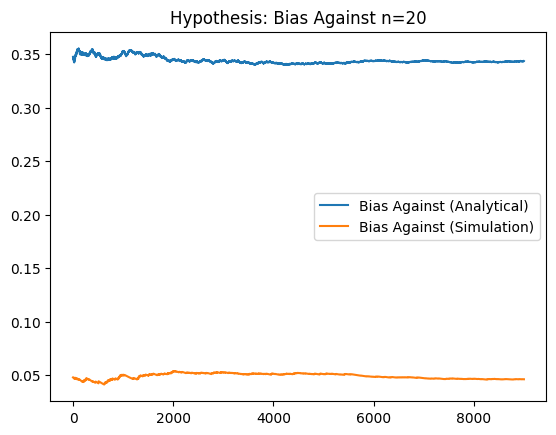

In [11]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time

def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

# Calculate the bias against the prior hypothesis
bias_against = idata.posterior["logBR_prior_pdl"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]  # Use 1000 samples
x_samples = idata.posterior['y_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pdl'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against n={}".format(n))
plt.legend()
plt.show()

In [4]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]
# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p)
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)
    mu = pm.Deterministic('mu', pm.math.dot(X, beta))

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma0**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma0**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta0))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yl_)) + pm.math.dot(Sigma_beta_inv, beta -delta)))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, cov=cov_beta_post, shape=p), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yu_)) + pm.math.dot(Sigma_beta_inv, beta +delta)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, cov=cov_beta_post, shape=p), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



y [-2.88658321  1.39692213  0.4990532   1.89535429  2.08015749  1.3356071
 -0.44807108 -3.07235428  1.83462689 -3.24733947]


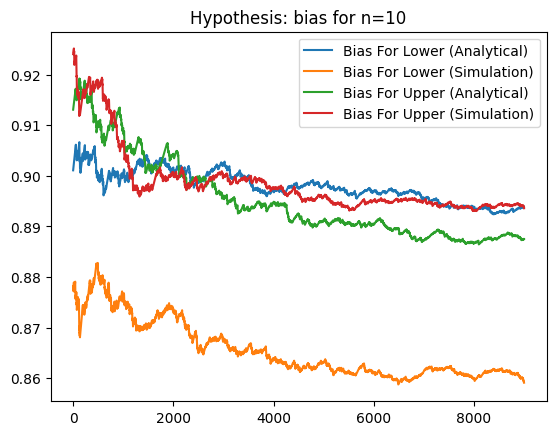

In [5]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [8]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]
# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)

print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)


with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p)
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)
    mu = pm.Deterministic('mu', pm.math.dot(X, beta))

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma0**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma0**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta0))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yl_)) + np.dot(Sigma_beta_inv, beta0)))
    #mean_betal = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + np.dot(Sigma_beta_inv, beta0))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, cov=cov_beta_post, shape=p), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yu_)) + np.dot(Sigma_beta_inv, beta0)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, cov=cov_beta_post, shape=p), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



y [ 5.15810967 -0.22659128  0.89591787 -0.01123575  2.80740303  3.3320926
 -0.86698382 -3.60342865 -0.80263237  1.69853562]


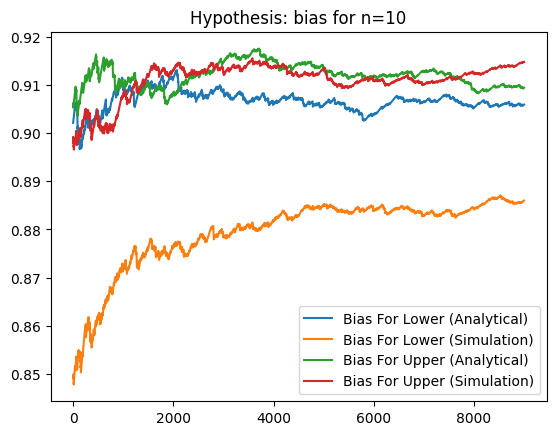

In [9]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()
